<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_5/Aula_5_Desafios_em_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparando o conteúdo anterior:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
### também posso usar o link no meu repositório

def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()

def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes # transformando em variaveis categoricas

modelo = LogisticRegression(max_iter=10000)
modelo_arvore = DecisionTreeClassifier()



In [11]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234) # lembrando sempre que é para valor didático
    dados = dados.sample(frac = 1).reset_index(drop = True) # embaralha
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    resultados = cross_validate(modelo, x, y, cv = cv, scoring = "roc_auc")

    auc_medio = np.mean(resultados["test_score"])
    auc_std = np.std(resultados["test_score"])

    print(f"AUC Médio {auc_medio}") 
    print(f"Intervalo {auc_medio - (2 * auc_std)} - {auc_medio + (2 * auc_std)}")


In [5]:
roda_modelo_cv(modelo, dados_limpos, 5, 10)

AUC Médio 0.7575511875511876
Intervalo 0.6366273412799195 - 0.8784750338224556


# Aula 5

In [7]:
roda_modelo_cv(modelo_arvore, dados_limpos, n_splits = 5, n_repeats = 10)

AUC Médio 0.6279279683391525
Intervalo 0.4988394445682657 - 0.7570164921100394


In [10]:
modelo_arvore = DecisionTreeClassifier(max_depth = 10)

roda_modelo_cv(modelo_arvore, dados_limpos, n_splits = 5, n_repeats = 10)

AUC Médio 0.5917582923832925
Intervalo 0.4430725313263285 - 0.7404440534402564


In [13]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234) # lembrando sempre que é para valor didático
    dados = dados.sample(frac = 1).reset_index(drop = True) # embaralha
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    resultados = cross_validate(modelo, x, y, cv = cv, scoring = "roc_auc", return_train_score = True)

    auc_medio = np.mean(resultados["test_score"])
    auc_medio_treino = np.mean(resultados["train_score"])
    auc_std = np.std(resultados["test_score"])

    print(f"AUC {auc_medio} - {auc_medio_treino}") 
    return auc_medio, auc_medio_treino

   # print(f"AUC Médio {auc_medio}") 
   # print(f"Intervalo {auc_medio - (2 * auc_std)} - {auc_medio + (2 * auc_std)}")


In [18]:
teste_lista = []
treino_lista = []

for i in range(1,15):
  modelo_arvore = DecisionTreeClassifier(max_depth = i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.5755830262080263 - 0.6445982993536308
AUC 0.6544700741411268 - 0.75415524801741
AUC 0.6643847795163584 - 0.8243714304989842
AUC 0.6554932930837536 - 0.8832038893699776
AUC 0.6475058192163456 - 0.9275331115338461
AUC 0.6239047951959137 - 0.9567921210944048
AUC 0.6117738776455882 - 0.9745102329260463
AUC 0.5987671815056683 - 0.9855938255169409
AUC 0.5877544694814432 - 0.991376822665679
AUC 0.5917582923832925 - 0.9946888385564852
AUC 0.6009579413444545 - 0.9970452758822465
AUC 0.6147261533363507 - 0.9986297665919551
AUC 0.6212348996723998 - 0.9994661199548005
AUC 0.6256292095025647 - 0.9998695491440995


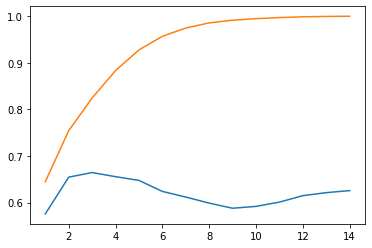

In [20]:
x = range(1, 15)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)

# exemplo, escolher max_depth de 3

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
teste_lista = []
treino_lista = []

for i in range(1,15):
  modelo_arvore = RandomForestClassifier(max_depth = i)
  teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)
  teste_lista.append(teste)
  treino_lista.append(treino)

AUC 0.7754785968683994 - 0.8549995635150238
AUC 0.7868632672744513 - 0.8976687127896622
AUC 0.7931550390103022 - 0.9403124842531797
AUC 0.7983565832578993 - 0.9709123570096604
AUC 0.7990938591103065 - 0.98788117359786
AUC 0.8004527808310704 - 0.9959760554693325
AUC 0.7994808369972844 - 0.9990287365273224
AUC 0.7977776116427432 - 0.9998630161707951
AUC 0.7963008103797579 - 0.9999847540078024
AUC 0.7927381904931247 - 1.0
AUC 0.7928442699577567 - 1.0
AUC 0.7923345025647657 - 1.0
AUC 0.7939161507500323 - 1.0
AUC 0.7939437314108367 - 1.0


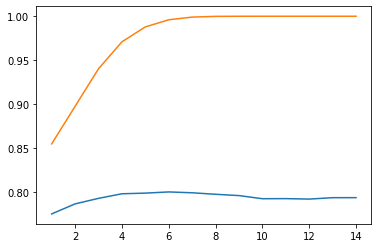

In [24]:
x = range(1, 15)
plt.plot(x, teste_lista)
plt.plot(x, treino_lista)


In [26]:
modelo_arvore = RandomForestClassifier(n_estimators = 10)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC 0.7428159147484805 - 0.999444041300827


In [27]:
modelo_arvore = RandomForestClassifier(n_estimators = 100)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)


AUC 0.7939557739557739 - 1.0


In [28]:
modelo_arvore = RandomForestClassifier(n_estimators = 200)
teste, treino = roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)


AUC 0.7950421219664641 - 1.0


# Desafio 01 - Deixar o gráfico de AUC "bonitão" (Silveira, Guilherme)

# Desafio 02 - Criar um sobreajuste com outra base de dados, outro modelo de ML e plotar o gráfico para análise (dica:base do titanic)

# Desafio 03 - Estudar um pouco mais sobre overfit e underfit

# Desafio 04 - Escolha um modelo de ML, estude os hiperparametros desse modelo e teste vários hiperparametros

# Desafio 05 - Pesquisar como salvar um modelo treinado